# import

In [2]:
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve,roc_curve
from sklearn.metrics import average_precision_score,roc_auc_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Draw_box_plot 

In [3]:
def draw_plot(file_name):
    sns.set(style="darkgrid",context="notebook",palette="deep",font_scale=1)
    to_plot=pd.read_csv('./edata/Save_for_drawing/'+file_name+'_box_plot.csv',index_col=None,sep=',')
    to_plot.replace({'modification':{0:'Unmodified',1:'Modified'}},inplace=True)
    fig,axes=plt.subplots(3,1,sharex=True,sharey=True)
    count=0
    for ax,features_to_plot in zip(axes,['event_stdv','event_mean','event_length']):
        sub_to_plot=to_plot[to_plot['feature']==features_to_plot].copy()
        LEN=len(sub_to_plot)
        sub_to_plot.sort_values(by='value',inplace=True)
        sub_to_plot=sub_to_plot.loc[sub_to_plot.index[int(LEN*0.1):int(LEN*0.9)]]
        sub_to_plot.value=(sub_to_plot.value-min(sub_to_plot.value))/(max(sub_to_plot.value)-min(sub_to_plot.value))    
        sns.boxplot(x='position',y='value',hue='modification',data=sub_to_plot,ax=ax,showfliers=False)#palette="Blues_d")
        if count==0:
            ax.set_title('Feature of '+file_name[-5:],fontsize=20)
        ax.set_ylabel('Normalized '+features_to_plot[6:],fontsize=10)
        ax.yaxis.set_label_position("left")
        ax.yaxis.set_tick_params(labelsize=12)
        ax.legend([],[],frameon=False)
        ax.set_xlabel('')
        count+=1
    ax.set_xlabel("Position",fontsize=20)
    ax.xaxis.set_tick_params(labelsize=10)
    handles,labels=ax.get_legend_handles_labels()
    fig.legend(handles,labels,loc="upper right",fontsize=10)
    plt.tight_layout(pad=1)
    fig.savefig('./edata/Save_drawing/'+file_name+'_Boxplots.pdf',bbox_inches='tight')

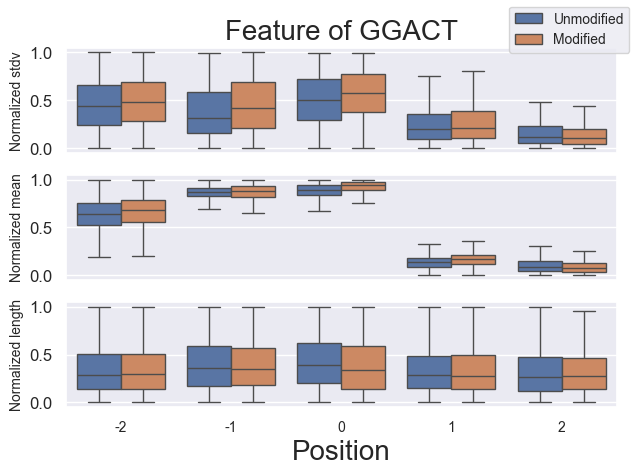

In [4]:
draw_plot('m6A_GGACT') 

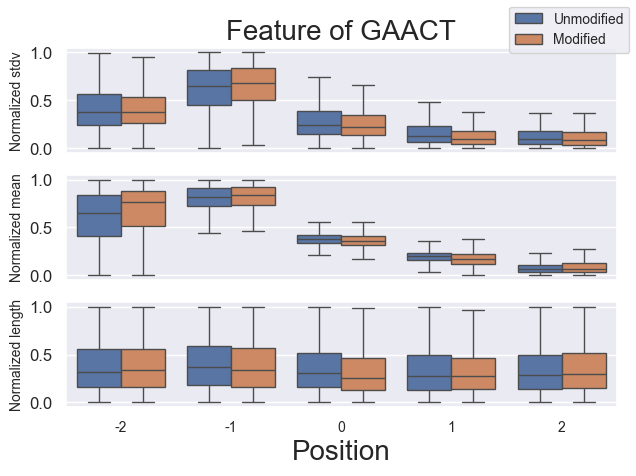

In [6]:
draw_plot('m6A_GAACT')

# Draw_curve

In [4]:
def draw_curve(label_pre_lis,s_name,no_dash_line=0):
    sns.set(style="darkgrid",context="notebook",palette="deep",font_scale=1.2)
    keep=[]
    for c_name in label_pre_lis:
        read_frame=pd.read_csv('./edata/Save_for_drawing/'+c_name+'_curve.csv')
        keep.append((c_name,np.array(read_frame['label']),np.array(read_frame['pred'])))
        
    for each in keep:
        roc_x,roc_y,_=roc_curve(each[1],each[2])
        plt.plot(roc_x,roc_y,lw=2,label=each[0]+' (area = %0.3f)'%roc_auc_score(each[1],each[2]))
    if no_dash_line==0:
        plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    fontsize=16
    plt.xlabel('False Positive Rate',fontsize=fontsize+4)
    plt.ylabel('True Positive Rate',fontsize=fontsize+4)
    plt.legend(loc="lower right")
    plt.tight_layout(pad=1)
    plt.savefig('./edata/Save_drawing/'+s_name+'_ROC.pdf',bbox_inches='tight')
    plt.show()

    for each in keep:
        roc_x,roc_y,_=roc_curve(each[1],each[2])
        preci,recall,_=precision_recall_curve(each[1],each[2])    
        plt.plot(recall,preci,lw=2,label=each[0]+' (area = %0.3f)'%average_precision_score(each[1],each[2]))
    plt.xlabel('Recall',fontsize=fontsize+4)
    plt.ylabel('Precision', fontsize=fontsize+4)
    plt.legend(loc="lower left")
    plt.tight_layout(pad=1)
    plt.savefig('./edata/Save_drawing/'+s_name+'_PR.pdf',bbox_inches='tight')
    plt.show()

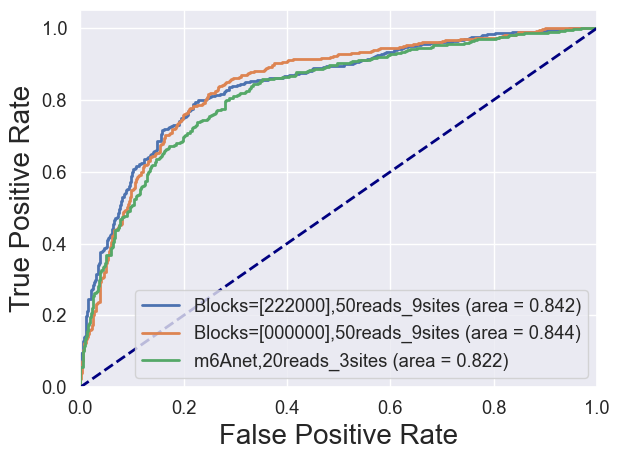

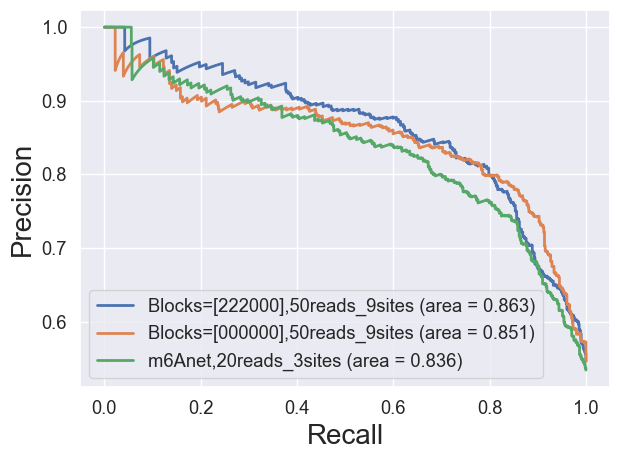

In [7]:
draw_curve(['Blocks=[222000],50reads_9sites','Blocks=[000000],50reads_9sites'\
           ,'m6Anet,20reads_3sites'],'main')

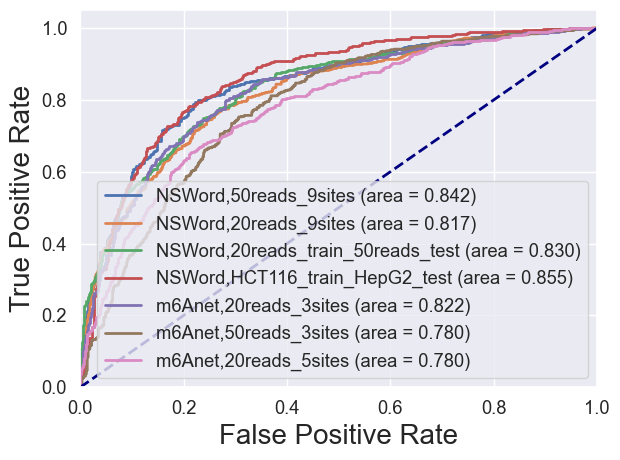

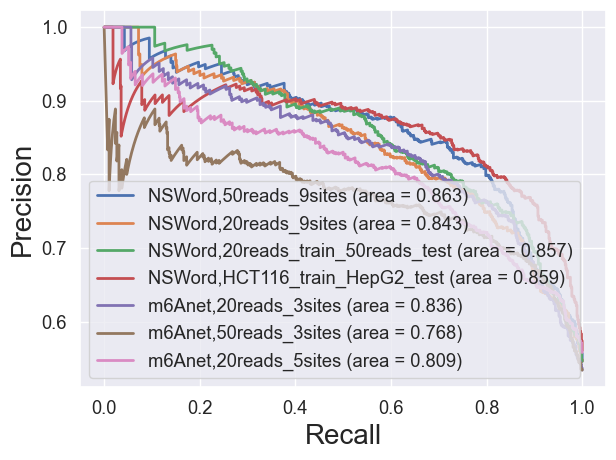

In [6]:
draw_curve(['NSWord,50reads_9sites','NSWord,20reads_9sites','NSWord,20reads_train_50reads_test','NSWord,HCT116_train_HepG2_test',\
            'm6Anet,20reads_3sites','m6Anet,50reads_3sites','m6Anet,20reads_5sites'],'diff')

# Draw_motif_histo

In [13]:
def draw_motif_histo(label_pre,s_name):
    sns.set(style="darkgrid",context="notebook",palette="deep",font_scale=1.2)
    read_frame=pd.read_csv('./edata/Save_for_drawing/'+label_pre+'_motif_histo.csv',index_col=0)
    read_frame.index.name='Motifs'
    read_frame['Total Count']=read_frame['TP']+read_frame['TN']+read_frame['FP']+read_frame['FN']
    read_frame=read_frame.sort_values(by='Total Count',ascending=False)

    TP_read_frame=read_frame.copy()
    TP_read_frame.insert(loc=4,column='Prediction',value='TP')
    TP_read_frame.insert(loc=5,column='Count',value=TP_read_frame['TP'])
    TN_read_frame=read_frame.copy()
    TN_read_frame.insert(loc=4,column='Prediction',value='TN')
    TN_read_frame.insert(loc=5,column='Count',value=TN_read_frame['TN'])
    T_frame=pd.concat([TP_read_frame,TN_read_frame])
    
    FN_read_frame=read_frame.copy()
    FN_read_frame.insert(loc=4,column='Prediction',value='FN')
    FN_read_frame.insert(loc=5,column='Count',value=FN_read_frame['FN'])
    FP_read_frame=read_frame.copy()
    FP_read_frame.insert(loc=4,column='Prediction',value='FP')
    FP_read_frame.insert(loc=5,column='Count',value=FP_read_frame['FP'])
    F_frame=pd.concat([FN_read_frame,FP_read_frame])
    
    T_frame['Percent']=T_frame['Count']/(T_frame['Count']+F_frame['Count'])
    F_frame['Percent']=F_frame['Count']/(T_frame['Count']+F_frame['Count'])
    T_frame=T_frame.fillna(0)
    F_frame=F_frame.fillna(0)
    
    F_frame['Count']+=T_frame['Count']
    F_frame['Percent']+=T_frame['Percent']

    plt.figure(figsize=[12,9])
    sns.barplot(x='Motifs',y='Count',hue='Prediction',data=F_frame,palette='Reds_d')
    sns.barplot(x='Motifs',y='Count',hue='Prediction',data=T_frame,palette='Blues_d')
    plt.legend(loc="upper right",fontsize=18)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=16)
    plt.xlabel('Motifs',fontsize=22)
    plt.ylabel('Count',fontsize=22)
    plt.tight_layout(pad=5)
    plt.savefig('./edata/Save_drawing/'+s_name+'_motif_Count.pdf',bbox_inches='tight')
    plt.show()

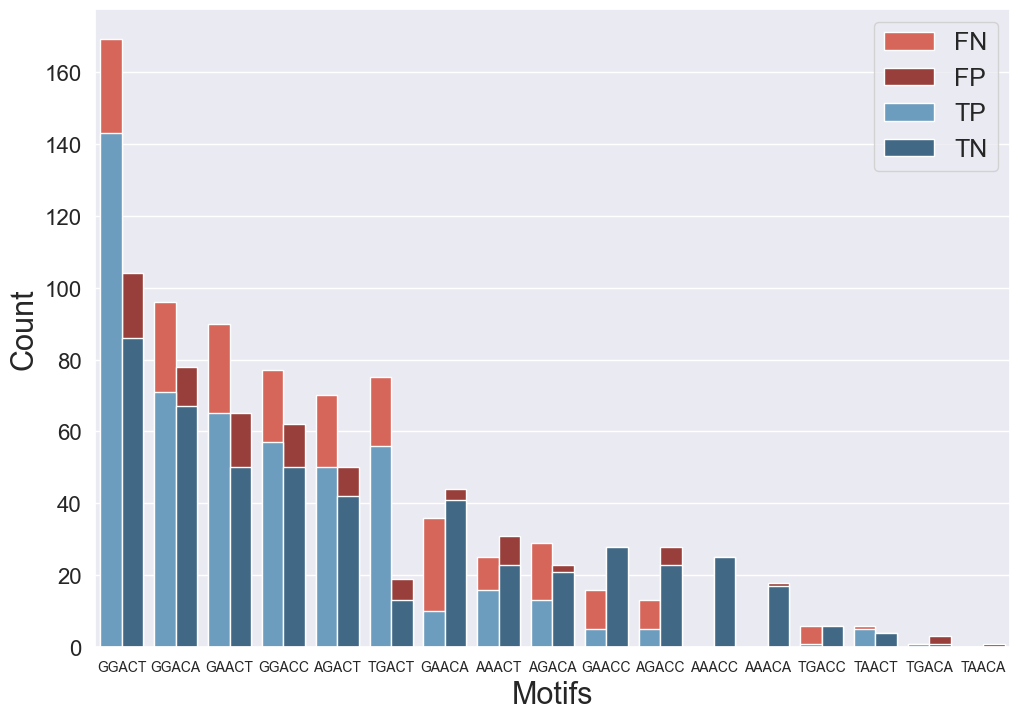

In [14]:
draw_motif_histo('Blocks=[222000],50reads_9sites','Conventional')

In [15]:
label_pre='Blocks=[222000],50reads_9sites'
read_frame=pd.read_csv('./edata/Save_for_drawing/'+label_pre+'_motif_histo.csv',index_col=0)
read_frame

,TP,FP,TN,FN
GAACT,65,15,50,25
GGACA,71,11,67,25
GGACT,143,18,86,26
AGACT,50,8,42,20
GGACC,57,12,50,20
AAACC,0,0,25,0
AGACA,13,2,21,16
TGACT,56,6,13,19
AGACC,5,5,23,8
AAACT,16,8,23,9


In [9]:
def calc(TP,FP,TN,FN):
    FPR=FP/(TN+FP)
    FNR=FN/(TP+FN)
    D=FPR-FNR
    print(D)
print('GGACT')
calc(143,18,86,26)
print('GGACA')
calc(71,11,67,25)
print('GAACA')
calc(10,3,41,26)
print('GAACC')
calc(5,0,28,11)

GGACT
0.019230769230769218
GGACA
-0.11939102564102566
GAACA
-0.654040404040404
GAACC
-0.6875


# Draw_range_histo

In [17]:
def draw_range_histo(label_pre,s_name):
    sns.set(style="darkgrid",context="notebook",palette="deep",font_scale=1.2)
    read_frame=pd.read_csv('./edata/Save_for_drawing/'+label_pre+'_range_histo.csv')
    Copy=read_frame.loc[:,'Ground Truth'].copy()
    Copy[read_frame['Ground Truth']==0]='Unmodified'
    Copy[read_frame['Ground Truth']==1]='Modified'
    read_frame['Ground Truth']=Copy
    sns.displot(data=read_frame,x='Probability score',hue='Ground Truth',bins=np.linspace(0,1,11),kde=True,stat="probability",multiple="dodge")#dodge
    plt.xlabel('Probability score',fontsize=18)
    plt.ylabel('Proportion',fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig('./edata/Save_drawing/'+s_name+'_score_distribution.pdf',bbox_inches='tight')
    plt.show()

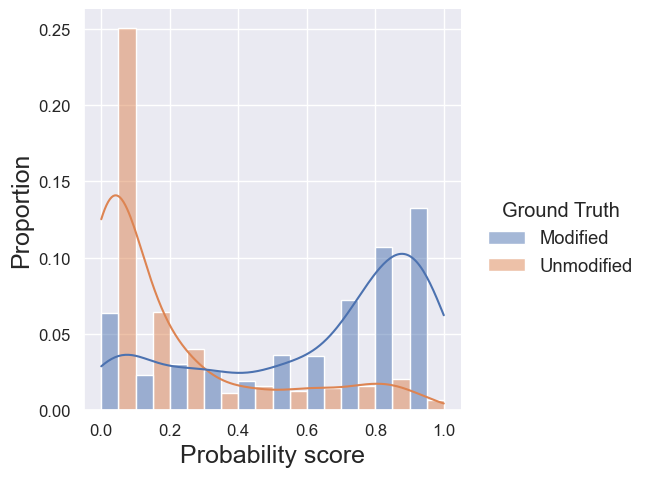

In [18]:
draw_range_histo('Blocks=[222000],50reads_9sites','Conventional')